## Implementation of the Face Recognition Model from FaceNet

I will be using stochastic gradient descent, which deviates from the use of mini-batch gradient descent in the FaceNet paper. For each epoch, I will be creating a list of (Anchor,Pos ex., Neg ex.) pairs which corresponds to all anchor positive pairs and the selection of semi-hard negatives based on encoding vector distances. Note - in order to create a low-variance, this model can be trained on images of a ton of different unique people.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras import backend as K
import matplotlib.pyplot as plt
import latex
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Loading data
names = np.load("../../data/facenet/names.npy")
images = np.load("../../data/facenet/images.npy")
print(names.shape)
print(images.shape)

(426,)
(426, 220, 220, 3)


### Tensorflow Parameters

Note - there are three outputs from the placeholder function corresponding to a placeholder for an anchor image, a positive image, and a negative image.

In [3]:
# Placeholder values for input image data
def get_placeholders(x_h,x_w,x_c):
    """
    x_h: Height for image input 
    x_w: Width for image input
    x_c: Channels for image input
    """
    anchor = tf.placeholder(tf.float32, name="anchor", shape=(None,x_h,x_w,x_c))
    pos = tf.placeholder(tf.float32, name="pos_ex", shape=(None,x_h,x_w,x_c))
    neg = tf.placeholder(tf.float32, name="neg_ex", shape=(None,x_h,x_w,x_c))
    return [anchor,pos,neg]

In [4]:
# Testing placeholders function
tf.reset_default_graph()
with tf.Session() as sess:
    anch,pos,neg = get_placeholders(220,220,3)
    print("Anchor shape:",anch.shape)
    print("Pos. example shape:",pos.shape)
    print("Neg. example shape:",neg.shape)

Anchor shape: (?, 220, 220, 3)
Pos. example shape: (?, 220, 220, 3)
Neg. example shape: (?, 220, 220, 3)


### Tensorflow forward prop

Using the NN1 architecture outlined in the FaceNet paper. Note - I adjust this model slightly, in that I add batch normalization during the convolution steps to increase training time and simultaneously handle regularization concerns. I also slightly alter the fully-connected layers steps.

In [5]:
def forward_pass(input_images):
    img1,img2,img3 = input_images
    img_enc1 = conv_network(img1)
    img_enc2 = conv_network(img2)
    img_enc3 = conv_network(img3)
    return [img_enc1,img_enc2,img_enc3]

In [6]:
# Defining constant layer for 2d convolution, batch norm, and activation
def conv(the_input,layer,f,ks,s):
    """
    the_input: the layer which will be used as input in conv layer
    layer: specifies the layer number for naming sections of graph
    f (filters): the number of filters to be used for conv layer
    ks (kernel_size): kernel size for conv2d layer
    s: stride for conv2d layer
    """
    layer = str(layer)
    Z = tf.layers.conv2d(the_input,filters=f,kernel_size=[ks,ks],strides=(s,s),padding="same",name="Z"+layer,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0),reuse=tf.AUTO_REUSE)
    Bn = tf.layers.batch_normalization(Z,name="Bn"+layer,reuse=tf.AUTO_REUSE)
    A = tf.nn.relu(Bn,name="A"+layer)
    return A

In [7]:
# NN1 architecture outlined in FaceNet paper with slight adjustments
def conv_network(X):
    input_layer = tf.reshape(X,[-1,220,220,3]) # Input shape of images
    S1 = conv(input_layer,1,64,7,2) # 110x110x64 
    P1 = tf.layers.max_pooling2d(S1,pool_size=[3,3],strides=2,padding="same",name="P1")
    S2 = conv(P1,2,64,1,1)
    S3 = conv(S2,3,192,3,1)
    P3 = tf.layers.max_pooling2d(S3,pool_size=[3,3],strides=2,padding="same",name="P3")
    S4 = conv(P3,4,192,1,1)
    S5 = conv(S4,5,384,3,1)
    P5 = tf.layers.max_pooling2d(S5,pool_size=[3,3],strides=2,padding="same",name="P5")
    S6 = conv(P5,6,384,1,1)
    S7 = conv(S6,7,256,3,1)
    S8 = conv(S7,8,256,1,1)
    S9 = conv(S8,9,256,3,1)
    S10 = conv(S9,10,256,1,1)
    S11 = conv(S10,11,256,3,1)
    P11 = tf.layers.max_pooling2d(S11,pool_size=[3,3],strides=2,padding="same",name="P11")
    # Reshape and maxout,fully connected layers
    Mo1 = tf.contrib.layers.maxout(P11,128) # 7x7x128
    F = tf.layers.flatten(Mo1,name="Flatten")
    Fc1 = tf.layers.dense(F,4096,activation=tf.nn.relu,name="Fc1",reuse=tf.AUTO_REUSE)
    Do = tf.layers.dropout(Fc1,rate=0.2,name="Dropout")
    Fc2 = tf.layers.dense(Do,128,activation=None,name="Fc2",reuse=tf.AUTO_REUSE)
    return Fc2

In [8]:
# Testing forward prop
tf.reset_default_graph()
img1,img2,img3 = images[0],images[1],images[2]
img1.shape = (1,220,220,3)
img2.shape = (1,220,220,3)
img3.shape = (1,220,220,3)
with tf.Session() as sess:
    aimg1,aimg2,aimg3 = get_placeholders(220,220,3)
    embeddings = forward_pass([aimg1,aimg2,aimg3])
    init = tf.global_variables_initializer()
    sess.run(init)
    aembedding = sess.run(embeddings,feed_dict={aimg1:img1,aimg2:img2,aimg3:img3})
    print("Anchor embedding shape:", str(aembedding[0].shape))
    print("Positive embedding shape:", str(aembedding[1].shape))
    print("Negative embedding shape:", str(aembedding[2].shape))

Anchor embedding shape: (1, 128)
Positive embedding shape: (1, 128)
Negative embedding shape: (1, 128)


### Tensorflow Triplet Loss

$$ J = \sum_{i=1}^{m} \bigg[ || f(x_i^a) - f(x^p_i) ||_2^2 - || f(x_i^a) - f(x^n_i) ||_2^2 + \alpha \bigg] $$
Note - I am not normalizing encoding vectors.

Terms:
- alpha: margin (set to 0.2 here)
- x<sub>i</sub><sup>a</sup>: anchor encoding
- x<sub>i</sub><sup>p</sup>: positive example encoding
- x<sub>i</sub><sup>n</sup>: negative example encoding

In [9]:
# Input embeddings is a list of three (None,128) embeddings
def cost_function(embeddings,alpha=0.2):
    anchor,pos,neg = embeddings
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,pos)))
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,neg)))
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [10]:
# Testing cost function
tf.reset_default_graph()
img1,img2,img3 = images[0],images[1],images[2]
img1.shape,img2.shape,img3.shape = (1,220,220,3),(1,220,220,3),(1,220,220,3)
with tf.Session() as sess:
    aimg1,aimg2,aimg3 = get_placeholders(220,220,3)
    embeddings = forward_pass([aimg1,aimg2,aimg3])
    cost = cost_function(embeddings) 
    init = tf.global_variables_initializer()
    sess.run(init)
    acost = sess.run(cost,feed_dict={aimg1:img1,aimg2:img2,aimg3:img3})
    print("cost:",acost)
    print("cost shape:",cost.shape)

cost: 22.259579
cost shape: ()


### Getting training pairs 

In order to create training pairs, I will be shuffling the dataset of image,name pairs for each epoch. I will be using 20 images of each person as anchor images, and each image will have 10 unique positive pairs. For each of these anchor,positive pairs I will be calculating the distance between the (1,128) encodings. In order to get a negative pair I will be comparing the distance of the (1,128) encodings between the anchor and positive ex. to other images of different people and picking an image such that the distance between the (1,128) encoding of the anchor and negative ex. is greater than the distance between the anchor and positive example (semi-hard negatives).

Picking negative example based on criteria:

$$ || f(x_i^a) - f(x^p_i) ||_2^2 < || f(x_i^a) - f(x^n_i) ||_2^2 $$ 

In [11]:
# Calculates the distance between two vector embeddings
# enc1 (anchor),enc2: shape (1,128)
def distance(enc1,enc2):
    return np.sum(np.square(np.subtract(enc1,enc2)))

In [12]:
# Return a list of (Anchor,Pos ex.,Neg ex.) groupings, creating a list of around 2000 each time called
def get_groupings(names,images,encodings,seed):
    groupings = []
    # Creating list of pairs: (name,img,encoding)
    pairs = [(names[i],images[i],encodings[i]) for i in range(names.shape[0])]
    # Shuffle and reorder
    pairs = shuffle(pairs)
    pairs.sort(key=lambda pair: pair[0]) # group same people together
    # Initializing count for each person
    count = {'KA':0, 'KL':0, 'KM':0, 'KR':0, 'MK':0, 'NA':0, 'NM':0, 'TM':0, 'UY':0, 'YM':0}
    
    for i in range(len(pairs)):
        if count[pairs[i][0]] < 20: # want 20 of each person, pairs[i][0] is name
            count[pairs[i][0]] += 1
            
            for j in range(1,11): # want 10 pos ex. per anchor image
                if pairs[i][0] == pairs[i+j][0]: # ensure still the same person
                    pos_dist = distance(pairs[i][2],pairs[i+j][2]) # pos encoding distance
                    pairs_shuff = shuffle(pairs) # larger chance for different negative examples, called 2000 times
                
                    for pair in pairs_shuff:
                        if pair[0] != pairs[i][0]: # different person
                            neg_dist = distance(pairs[i][2],pair[2])
                            if neg_dist > pos_dist: # found valid neg. example
                                groupings.append((pairs[i][1],pairs[i+j][1],pair[1])) # (anchor,pos,neg)
                                break
                            
    return groupings

In [13]:
# Getting image encodings
tf.reset_default_graph()
with tf.Session() as sess:
    X = tf.placeholder(tf.float32, name="imgs", shape=(None,220,220,3))
    Z = conv_network(X) # getting encodings
    init = tf.global_variables_initializer()
    sess.run(init)
    embeddings = sess.run(Z,feed_dict={X:images})
    print("shape of embeddings:",embeddings.shape)

shape of embeddings: (426, 128)


In [14]:
# Testing groupings
groupings = get_groupings(names,images,embeddings,1)
print("number of groupings:",len(groupings))

number of groupings: 1994


### Tensorflow Model

In [18]:
# Using stochastic gradient descent
def model(images,names,lr=0.0001,num_epochs=5,print_cost=True):
    tf.reset_default_graph() # resetting graph
    tf.set_random_seed(1)
    seed=0
    costs=[]
    x_h = images[0].shape[0]
    x_w = images[0].shape[1]
    x_c = images[0].shape[2]
    
    anch,pos,neg = get_placeholders(x_h,x_w,x_c)
    embeddings = forward_pass([anch,pos,neg])
    cost = cost_function(embeddings)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() # to save/load model
    with tf.Session() as sess:
        # Loading saved model
        saver = tf.train.import_meta_graph("../../data/facenet/models_stochastic/yolo_model.ckpt.meta")
        saver.restore(sess, "../../data/facenet/models_stochastic/yolo_model.ckpt")
        #sess.run(init) # DON'T RUN INIT IF LOADING MODEL
        
        for epoch in range(num_epochs):
            running_cost = 0
            seed += 1
            # get training data for each epoch
            imgs_ex = tf.placeholder(tf.float32, shape=(None,220,220,3))
            emb = conv_network(imgs_ex) # getting embeddings
            embeddings = sess.run(emb,feed_dict={imgs_ex:images})
            groupings = get_groupings(names,images,embeddings,seed)

            for group in groupings:
                anchor,pos_ex,neg_ex = group
                anchor.shape = (1,220,220,3)
                pos_ex.shape = (1,220,220,3)
                neg_ex.shape = (1,220,220,3)
                _,temp_cost = sess.run([optimizer,cost], feed_dict={anch:anchor,pos:pos_ex,neg:neg_ex})
                running_cost += temp_cost
                #print("running cost: "+str(running_cost) + " ,temp_cost: " + str(temp_cost))
                
            costs.append(running_cost)
            if print_cost and epoch % 1 == 0:
                print("Cost at epoch {}: {}".format(epoch+1,running_cost))
                
        loc = saver.save(sess, "../../data/facenet/models_stochastic/yolo_model.ckpt")
        return costs

In [16]:
# I interpret these costs as the model finding different local minima
acosts1 = model(images,names,lr=0.00001,num_epochs=10,print_cost=True)

Cost at epoch 1: 58.67493022978306
Cost at epoch 2: 19.080452010035515
Cost at epoch 3: 37.33539454638958
Cost at epoch 4: 22.211405813694
Cost at epoch 5: 21.23913362622261
Cost at epoch 6: 9.610294818878174
Cost at epoch 7: 18.731493830680847
Cost at epoch 8: 10.713260143995285
Cost at epoch 9: 4.189636364579201
Cost at epoch 10: 17.807087048888206


In [19]:
acosts2 = model(images,names,lr=0.000002,num_epochs=5,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/facenet/models_stochastic/yolo_model.ckpt
Cost at epoch 1: 16.147534355521202
Cost at epoch 2: 15.548249021172523
Cost at epoch 3: 3.5364754647016525
Cost at epoch 4: 6.057818606495857
Cost at epoch 5: 4.47528463602066


In [20]:
acosts3 = model(images,names,lr=0.000001,num_epochs=5,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/facenet/models_stochastic/yolo_model.ckpt
Cost at epoch 1: 0.9283778071403503
Cost at epoch 2: 1.0710631906986237
Cost at epoch 3: 1.8821271657943726
Cost at epoch 4: 0.37509244680404663
Cost at epoch 5: 0.6142970770597458


In [21]:
acosts4 = model(images,names,lr=0.0000001,num_epochs=5,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/facenet/models_stochastic/yolo_model.ckpt
Cost at epoch 1: 0.44758440554142
Cost at epoch 2: 0.23273101449012756
Cost at epoch 3: 0.3791549652814865
Cost at epoch 4: 0.4613723158836365
Cost at epoch 5: 0.36153310537338257


In [22]:
acosts5 = model(images,names,lr=0.000000005,num_epochs=5,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/facenet/models_stochastic/yolo_model.ckpt
Cost at epoch 1: 0.0
Cost at epoch 2: 0.18420949578285217
Cost at epoch 3: 0.40793846547603607
Cost at epoch 4: 0.1281431019306183
Cost at epoch 5: 0.22895649075508118


### Using the model

Taking an image of a specific person and comparing it to a list of a single image of all of the people in the training set to see if the input image is most similar to the image of the same person in the list of single images.

In [23]:
# Getting image encoding
tf.reset_default_graph()
input_images = tf.placeholder(tf.float32,shape=(None,220,220,3))
image_embeddings = conv_network(input_images)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("../../data/facenet/models_stochastic/yolo_model.ckpt.meta")
    saver.restore(sess, "../../data/facenet/models_stochastic/yolo_model.ckpt")
    final_embeddings = sess.run(image_embeddings,feed_dict={input_images:images})

INFO:tensorflow:Restoring parameters from ../../data/facenet/models_stochastic/yolo_model.ckpt


In [24]:
final_embeddings.shape

(426, 128)

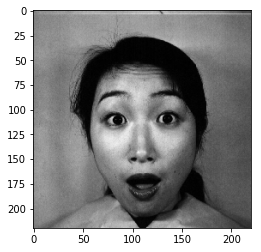

Name: KA


In [32]:
# Anchor image for comparison
anchor_encoding = final_embeddings[20]
plt.imshow(images[20])
plt.show()
print("Name:",names[20])

In [34]:
# Getting index for each unique person in dataset, for comparison
names_i = list(names)
KA_i = names_i.index('KA')
KL_i = names_i.index('KL')
KM_i = names_i.index('KM')
KR_i = names_i.index('KR')
MK_i = names_i.index('MK')
NA_i = names_i.index('NA')
NM_i = names_i.index('NM')
TM_i = names_i.index('TM')
UY_i = names_i.index('UY')
YM_i = names_i.index('YM')

#### You will notice that the image with the encoding most similar to the anchor image is another image of the same person, but with a different expression.

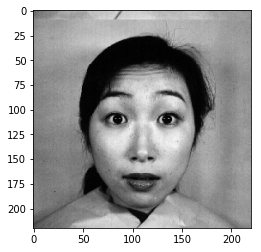

Name: KA
Embedding dist: 1.0708238


In [36]:
plt.imshow(images[KA_i])
plt.show()
print("Name:",names[KA_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[KA_i]))

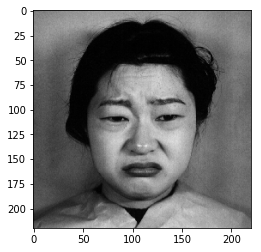

Name: KL
Embedding dist: 2.8243017


In [37]:
plt.imshow(images[KL_i])
plt.show()
print("Name:",names[KL_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[KL_i]))

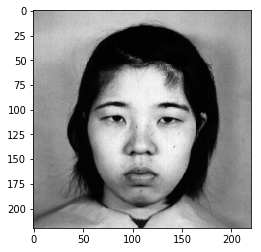

Name: KM
Embedding dist: 3.818933


In [38]:
plt.imshow(images[KM_i])
plt.show()
print("Name:",names[KM_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[KM_i]))

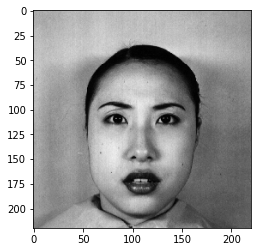

Name: KR
Embedding dist: 3.36743


In [39]:
plt.imshow(images[KR_i])
plt.show()
print("Name:",names[KR_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[KR_i]))

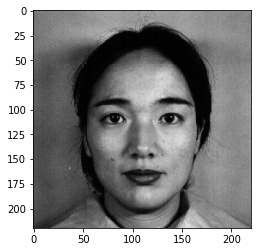

Name: MK
Embedding dist: 3.2806535


In [40]:
plt.imshow(images[MK_i])
plt.show()
print("Name:",names[MK_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[MK_i]))

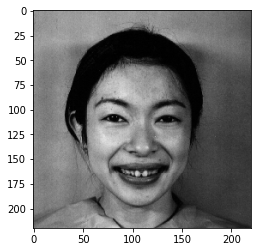

Name: NA
Embedding dist: 2.1233377


In [41]:
plt.imshow(images[NA_i])
plt.show()
print("Name:",names[NA_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[NA_i]))

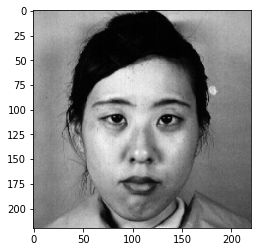

Name: NM
Embedding dist: 2.909689


In [42]:
plt.imshow(images[NM_i])
plt.show()
print("Name:",names[NM_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[NM_i]))

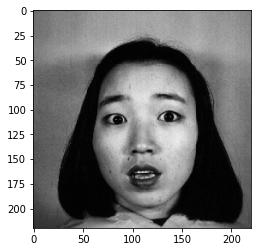

Name: TM
Embedding dist: 7.0104876


In [43]:
plt.imshow(images[TM_i])
plt.show()
print("Name:",names[TM_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[TM_i]))

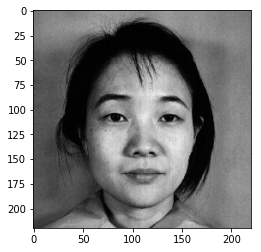

Name: UY
Embedding dist: 5.9368205


In [44]:
plt.imshow(images[UY_i])
plt.show()
print("Name:",names[UY_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[UY_i]))

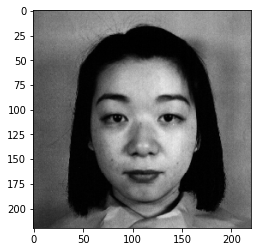

Name: YM
Embedding dist: 5.028965


In [45]:
plt.imshow(images[YM_i])
plt.show()
print("Name:",names[YM_i])
print("Embedding dist:",distance(anchor_encoding,final_embeddings[YM_i]))